In [18]:
%config Completer.use_jedi = False #Makes stuff faster in VS code (maybe)

# Fit the geometry and index grains from a single scan

In [19]:
#Export an evironment variable related to SLURM
%env SLURM_CPUS_PER_TASK=7

env: SLURM_CPUS_PER_TASK=7


In [20]:
import h5py, hdf5plugin
import os
import ImageD11.sinograms.dataset, ImageD11.sinograms.properties
import ImageD11.unitcell
import matplotlib.pyplot as plt
%matplotlib widget

#### Set parameters

In [21]:
sample='SiMo1000_6_v2'
scan_name = '05_0N_3DXRD'
scan_id = '5.1'
analysisroot ='/Users/al8720/Library/CloudStorage/OneDrive-Malmöuniversitet/projects/castIron/ESRF22/analysis_23/tdxrd/linebeam'
parfile = '/Users/al8720/Library/CloudStorage/OneDrive-Malmöuniversitet/projects/castIron/ESRF22/analysis_23/tdxrd/bccFrelon_unfitted.par'

splinefile = '/Users/al8720/Library/CloudStorage/OneDrive-Malmöuniversitet/projects/castIron/ESRF22/analysis_23/tdxrd/frelon36.spline'


#### Fit the geometry using one scan

In [22]:
h5ds = os.path.join(analysisroot,sample,scan_name,f'ds_{scan_name}.h5')
h5peaks = os.path.join(analysisroot,sample,scan_name,f'pks_{scan_name}_{scan_id}.h5')
ds = ImageD11.sinograms.dataset.load(h5ds)
pks_table = ImageD11.sinograms.properties.pks_table.load(h5peaks)

In [23]:
pks_2d_dict = pks_table.pk2d(ds.omega,ds.dty) #peaks on each frame
pks_3d_dict = pks_table.pk2dmerge(ds.omega,ds.dty) #merge peaks in omega (and dty) TODO: this might be able to merge in z
print(f"{len(pks_2d_dict['s_raw'])} unmerged peaks")
print(f"{len(pks_3d_dict['s_raw'])} merged peaks")

796690 unmerged peaks
144606 merged peaks


In [67]:
import ImageD11.blobcorrector
import ImageD11.columnfile
import ImageD11.refinegrains
import ImageD11.transformer
import ImageD11.indexing
import ImageD11.grain
import numpy as np
import sys

def tocolf(pks,parfile,splinefile,plot=False):
    #Correct peak positions using the spline file
    #preallocate sc and fc in the dictionary
    pks['sc']=np.zeros(len(pks['f_raw']))
    pks['fc']=np.zeros(len(pks['f_raw']))
    corrector = ImageD11.blobcorrector.correctorclass(splinefile)
    for i in range(len(pks['sc'])):
        pks['sc'][i],pks['fc'][i]=corrector.correct(pks['s_raw'][i],pks['f_raw'][i])
    #make a columnfile object
    cf = ImageD11.columnfile.colfile_from_dict(pks)
    cf.parameters.loadparameters(parfile)
    cf.updateGeometry()
    if plot:
        fig,ax = plt.subplots(1,3)
        ax[0].scatter(cf.tth,cf.eta,s=0.001)
        ax[0].set_xlabel(r'$2\theta$')
        ax[0].set_ylabel(r'$\eta$')
        ax[1].scatter(cf.eta,cf.omega,s=0.001)
        ax[1].set_xlabel(r'$\eta$')
        ax[1].set_ylabel(r'$\omega$')
        ax[2].scatter(cf.omega,cf.tth,s=0.001)
        ax[2].set_xlabel(r'$\omega$')
        ax[2].set_ylabel(r'$2\theta$')

        # fig = plt.figure()
        # ax = fig.add_subplot(projection='3d')
        # ax.scatter(cf.tth,cf.eta,cf.omega,s=0.001)
        # ax.set_xlabel(r'$2\theta$')
        # ax.set_ylabel(r'$\eta$')
        # ax.set_zlabel(r'$\omega$')

    return cf

def select_strongest_peaks(colf, frac = 0.99, B=0.2,plot=False):
    #We will keep peaks corresponding to frac of the total intensity

    #This is a correction which I do not quite understand. 
    cor_intensity = colf.sum_intensity*np.exp(B*colf.ds**2)
    #Correct with Lorentz factor
    lf = ImageD11.refinegrains.lf(colf.tth,colf.eta)
    cor_intensity *= lf
    order = np.argsort(cor_intensity)[::-1] #sort the intensity in decreasing order
    sorted_intensity = cor_intensity[order]
    cums = np.cumsum(sorted_intensity)
    cums /= cums[-1] #scale to [0,1]
    #Find the index where the cumsum>frac
    enough = np.searchsorted(cums,frac)
    threshold = sorted_intensity[enough] #The lowest intensity value to keep
    mask = sorted_intensity > threshold
    print(f'Keeping {mask.sum()} strongest peaks')
    if plot:
        fig,ax = plt.subplots(1,2)
        ax[0].plot(cums,',')
        ax[0].set_xlabel('Number of peaks')
        ax[0].set_ylabel('Fractional cumulative intensity')
        ax[0].plot(mask.sum(),frac,'ro')
        ax[1].plot(colf.tth,colf.eta,',')
        ax[1].plot(colf.tth[mask],colf.eta[mask],',')
        ax[1].set_xlabel(r'$2\theta$')
        ax[1].set_ylabel(r'$\eta$')
    return mask

def fit_geometry(colf,parfile,nfits=6):
    colf.writefile('temp.h5') #save the columnfile to a file so that it can be read by transformer
    tr = ImageD11.transformer.transformer(parfile=parfile,fltfile='temp.h5')
    tr.updateparameters()
    plt.figure()
    plt.plot(colf.tth,colf.eta,',',label='Original')
    [tr.fit() for i in range(nfits)]
    tth,eta = tr.compute_tth_eta()
    plt.plot(tth,eta,',',label='Fitted')
    # plt.plot(tr.theorytth,[0]*len(tr.theorytth),'|',ms=50)
    plt.legend()
    print('Fitted parameters:')
    for key,val in tr.parameterobj.get_parameters().items():
        print(key, val)
    #save fitted parameters
    outname = parfile.replace('.par','_fitted.par')
    tr.saveparameters(outname)
    #update the colf
    colf.updateGeometry(tr.parameterobj)
    return colf, outname

def index(colf,
          max_multiplicity = 10,
          ds_tol = 0.01,
          max_grains=1000,
          npk_tol = [(200,0.02), (100,0.03)]):
    indexer = ImageD11.indexing.indexer_from_colfile(colf,
                                                     ds_tol=ds_tol,
                                                     max_grains=max_grains)
    indexer.assigntorings()
    indexer.hits=[]
    #find the low multiplicity rings
    rings=[]
    for i,d in enumerate(indexer.unitcell.ringds):
        if len(indexer.unitcell.ringhkls[d])<max_multiplicity:
            rings.append(i)
    for minpks, tol in npk_tol:
        indexer.minpks = minpks
        indexer.hkl_tol = tol
        for indexer.ring_1 in rings[::-1]:
            for indexer.ring_2 in rings[::-1]:
                indexer.find()
                if len(indexer.hits):
                    indexer.scorethem()
        #indexer.score_all_pairs(npairs)
    indexer.fight_over_peaks()
    return indexer

def plot_indexing(indexer,colf):
    indexer.histogram_drlv_fit()
    fig,ax = plt.subplots(1,3)
    for grh in indexer.histogram:
        ax[0].plot(indexer.bins[1:-2],grh[:-2])
    ax[0].set(ylabel='Number of peaks', xlabel='HKL - int(HKL)')
    m = indexer.ga == -1 #not indexed peaks
    ax[1].plot(colf.tth[~m],colf.eta[~m],'.',label='Indexed',alpha=0.5)
    ax[1].plot(colf.tth[m],colf.eta[m],'.',label='Not indexed',alpha=0.5)
    ax[1].legend()
    ax[2].hist(indexer.gas.T)
    ax[2].set(xlabel='Number of indexed peaks', ylabel='Number of grains')

def check_indexed_peaks(indexer,colf,hkl_tol=0.03,plot=False):
    gv = np.transpose((colf.gx,colf.gy,colf.gz)).copy() #array of g-vectors
    n = len(gv) #number of g-vectors
    drlv2 = np.full(n,2,dtype=float) #array of error metric
    labels = np.full(n,-1,'i') #label for g vectors according to grain
    grains = [ImageD11.grain.grain(ubi.copy()) for ubi in indexer.ubis] #array of grain objects
    print(f'The indexer contains {len(grains)} grains')
    for i, g in enumerate(grains): #for each grain
        g.alln = ImageD11.cImageD11.score(g.ubi,gv,hkl_tol) #number of g-vector that indexes the current grain
        npk = ImageD11.cImageD11.score_and_assign(g.ubi,gv,hkl_tol,drlv2, labels, i) #assigns labels and drlv2 to the grain if the drlv2 improves
        labels_free = np.full(n,-1,'i') #let the grain choose peaks freely
        drlv2_free= np.full(n,2,dtype=float) #array of error metric
        npk = ImageD11.cImageD11.score_and_assign(g.ubi,gv,hkl_tol,drlv2_free, labels_free, i) #assign peaks freely
        g.allpks = labels_free == i #these peaks where chosen
        g.isum = colf.sum_intensity[g.allpks].sum() #total intensity of the chosen reflections
    for i,g in enumerate(grains):
        g.pks = labels==i #these are the peaks belonging to grain i 
        g.npks = g.pks.sum()
        hkl_r = np.dot(g.ubi,gv[g.pks].T) #hkl (float) of the indexed peaks
        hkl_i = np.round(hkl_r).astype(int) #hkl rounded to integers
        uniqpks = np.unique(np.vstack((hkl_i,np.sign(colf.eta[g.pks]).astype(int))),axis=1) #find unique hkl combination or ones with different eta (not sure why eta)
        g.nuniq = uniqpks.shape[1] #number of unique peaks in this grain
    if plot:
        Imax = np.max([g.isum for g in grains])
        fig,ax = plt.subplots(1,3)
        ax[0].plot([g.npks for g in grains], [g.nuniq for g in grains],'+')
        ax[0].set(xlabel='Number of peaks', ylabel='Unique peaks')
        ax[1].scatter([g.alln for g in grains], [g.npks/g.alln for g in grains], s=[100*g.isum/Imax for g in grains],c=[i for i in range(len(grains))])
        ax[1].set(xlabel='Number of peaks total', ylabel='Fraction of assigned peaks')
        ax[2].semilogy([g.alln for g in grains], [g.isum for g in grains], '+')
        ax[2].set(xlabel='Number of peaks total', ylabel='Total intensity')
    return grains, labels, drlv2

def domap(  colf,
            grains,
            OmSlop=0.25,
            tolseq = [0.05,0.03,0.01],
            symmetry = 'cubic',
            nuniq = -1,
            npks = 10):
    """
    mapping function - does what makemap.py does, but in a function. More or less verbatim from ImageD11.grid_index_parallel
    """ 
    #disable printing
    ss = sys.stdout 
    sys.stdout = open('nul','w')      
    OmFloat= OmSlop > 0
    #
    for tol in tolseq:
        o = ImageD11.refinegrains.refinegrains( OmFloat = OmFloat, OmSlop = OmSlop,
                                       tolerance = tol,
                                       intensity_tth_range = (0,180),
                                       #latticesymmetry = symmetry
                                       )
        o.parameterobj = colf.parameters
        # o.loadfiltered ...
        o.scannames = ["internal"]
        o.scantitles = colf.titles
        o.scandata["internal"] = colf
        o.tolerance = tol
        # o.readubis( grainsfile )
        for i, g in enumerate(grains):
            name = i
            o.grainnames.append(i)
            o.ubisread[name] = g.ubi
            o.translationsread[name] = g.translation
        if symmetry != "triclinic":
            o.makeuniq( symmetry)
        o.generate_grains()
        o.refinepositions()

        # This fills in the uniq for each grain
        o.savegrains( 'nul', sort_npks = False)
        if nuniq >-1:
            keep = lambda g: g.nuniq > nuniq and g.npks > npks
        else:
            keep = lambda g: g.npks > npks
        gl = [ g for g in o.grains.values() if keep(g) ]
        if len(gl) == 0:
            break
        grains = gl

    #put back printing
    sys.stdout = ss
    return gl        




Keeping 25786 strongest peaks


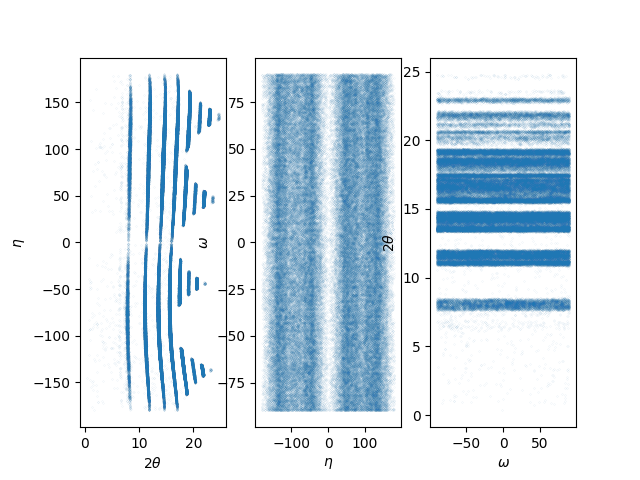

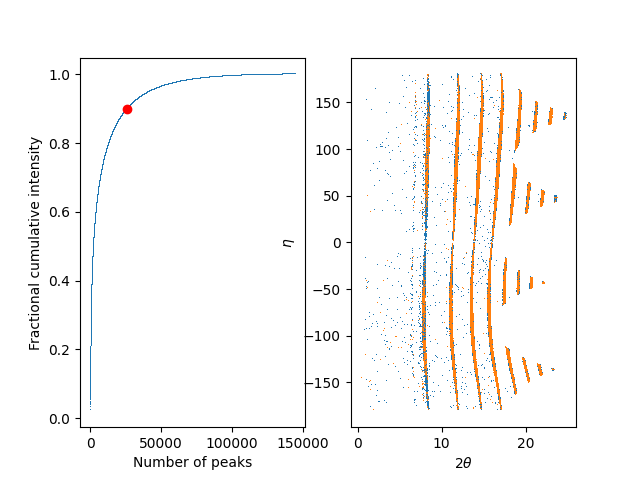

In [25]:
cf = tocolf(pks_3d_dict,parfile,splinefile,plot=True)
mask = select_strongest_peaks(cf,frac=0.9,B=0.2,plot=True)

Text(0, 0.5, '$I_{sum}$')

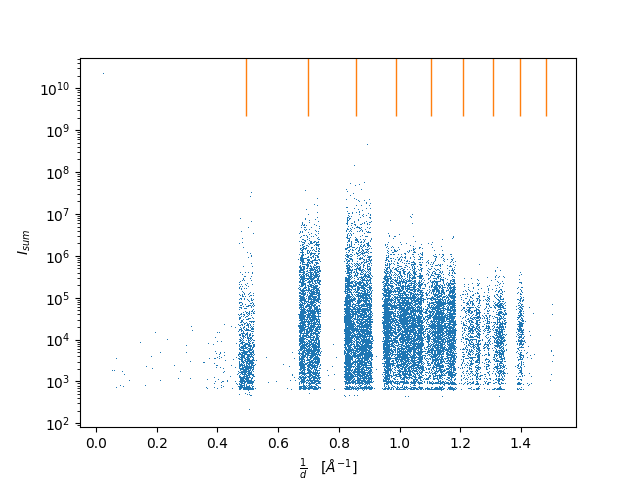

In [26]:
uc = ImageD11.unitcell.unitcell_from_parameters(cf.parameters)
uc.makerings(np.max(cf.ds))
plt.figure()
plt.plot(cf.ds[mask],cf.sum_intensity[mask],',')
plt.plot(uc.ringds,[np.max(cf.sum_intensity[mask])]*len(uc.ringds),'|',ms=60)
plt.semilogy()
plt.xlabel(r'$\frac{1}{d} \quad [Å^{-1}]$')
plt.ylabel(r'$I_{sum}$')


Tolerance for assigning peaks to rings 0.05 , min tth 0.0 , max tth 180.0
Iteration = 33   Best = 752.267353   Worst = 752.267519                           [1036.486966059913, 991.0938593835122, 148193.42028493312, -0.1075413038884076, -0.012762110562785286]
Tolerance for assigning peaks to rings 0.05 , min tth 0.0 , max tth 180.0
Iteration = 33   Best = 753.432005   Worst = 753.432262                              [1035.739676241721, 991.0074724884772, 148387.0975214965, -0.09118441382633882, -0.021068457654564627]
Tolerance for assigning peaks to rings 0.05 , min tth 0.0 , max tth 180.0
Iteration = 32   Best = 702.188031   Worst = 702.188242                               [1035.232423139294, 990.8001961583171, 148565.51645909806, -0.07528722828931628, -0.030264581409580396]
Tolerance for assigning peaks to rings 0.05 , min tth 0.0 , max tth 180.0
Iteration = 36   Best = 697.516573   Worst = 697.516822                               [1034.6985643484704, 990.8373672229422, 148694.79124244

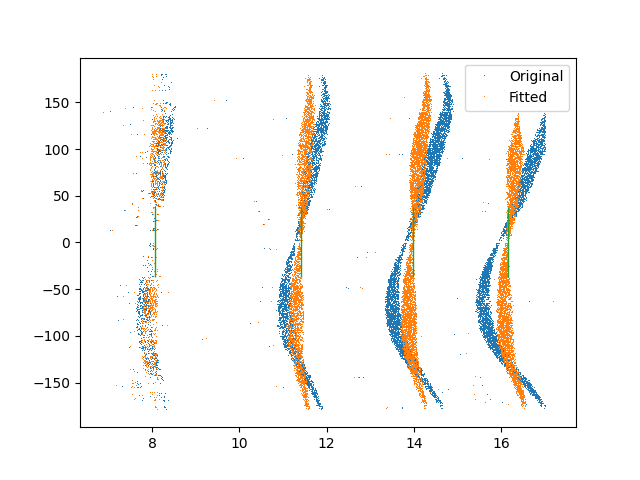

In [27]:
toindex = cf.copy()
toindex.filter(mask) #index only the strong peaks
#keep only the full rings
toindex.filter(toindex.tth>7)
toindex.filter(toindex.tth<17)

#fit the geometry
toindex, fitted_parfile = fit_geometry(toindex,parfile,nfits=10)


### Try to index something

In [28]:
#save the fitted parameters
cf.updateGeometry(toindex.parameters)
indexer = index(toindex,
                max_multiplicity=13,
                ds_tol=0.02,
                max_grains=200,
                npk_tol=[(40,0.01), (30,0.05)])

info: gv: [[-0.03579051 -0.14489855 -0.9986938 ]
 [-0.14041811 -0.13565624 -0.9889325 ]
 [-0.16306719 -0.1431539  -0.98273994]
 ...
 [-0.41113175  0.24091251 -0.71635894]
 [ 0.28345913 -0.39927328 -0.7265733 ]
 [ 0.28481587 -0.39756941 -0.72104653]] (16562, 3) float64
info: Assign to rings, maximum d-spacing considered: 1.050916
info: Ring assignment array shape (16562,)
info: Ring     (  h,  k,  l) Mult  total indexed to_index  ubis  peaks_per_ubi   tth
info: Ring 3   ( -2, -2,  0)   12   5108       0     5108   N/A     N/A  16.17
info: Ring 2   ( -2, -1, -1)   24   5885       0     5885   N/A     N/A  13.99
info: Ring 1   ( -2,  0,  0)    6   4026       0     4026   N/A     N/A  11.41
info: Ring 0   ( -1, -1,  0)   12   1271       0     1271   N/A     N/A  8.06
info: Using only those peaks which are assigned to rings for scoring trial matrices
info: Shape of scoring matrix (16290, 3)
info: hkls of rings being used for indexing
info: Ring 1: [(-2, -2, 0), (-2, 0, -2), (0, -2, -2), (0,

The indexer contains 337 grains


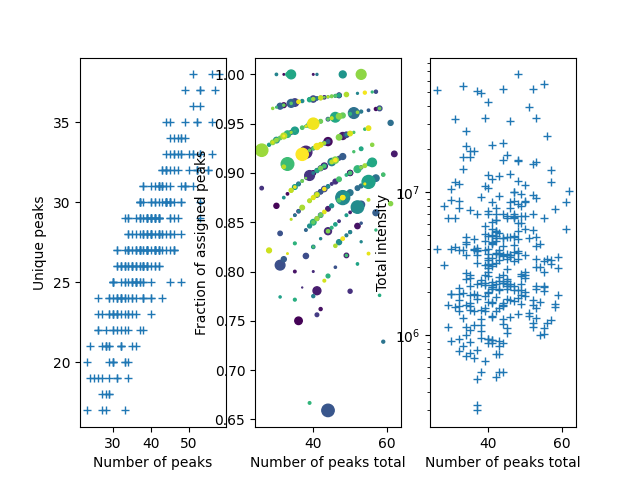

In [29]:
grains,labels, drlv2 = check_indexed_peaks(indexer,cf,plot=True)

#### Save the ubis

In [40]:
h5ubis = os.path.join(analysisroot,sample,scan_name,f'{scan_name}_{scan_id}_ubis.h5')
cf.addcolumn(labels,'labels')
cf.addcolumn(drlv2,'drlv2')
if os.path.exists(h5ubis):
    !rm {h5ubis} #remove the existing file
ImageD11.columnfile.colfile_to_hdf(cf,h5ubis)
with h5py.File(h5ubis,'a') as hout:
    hout.create_dataset('ubis', data = np.array([g.ubi for g in grains]))
    hout.create_dataset('ubis_allpks', data = np.array([g.allpks for g in grains]))
indexer.saveubis(h5ubis.replace('.h5','.ubi')) #not sure why both are needed

In [41]:
%%time
mapped_grains = domap(cf, grains, OmSlop=0.25, tolseq=[0.05,0.03])
mapname = os.path.join(analysisroot,sample,scan_name,f'{scan_name}_{scan_id}.map')
ImageD11.grain.write_grain_file(mapname, mapped_grains)

CPU times: user 3min 2s, sys: 55.4 s, total: 3min 57s
Wall time: 2min 5s


No reference lattice parameters supplied. Will use the average of all grains
Average parameters:  [2.8582683110071785, 2.8582683110071785, 2.8582683110071785, 90, 90, 90]


/Users/al8720/Library/CloudStorage/OneDrive-Malmöuniversitet/code/DDDXRD/dddxrd/utils/crystallography.py:99: RuntimeWarning: invalid value encountered in arccos
  beta = np.arccos(gn[0]/(gn[0]**2+gn[1]**2))


Text(0, 0.5, 'z CoM coordinate')

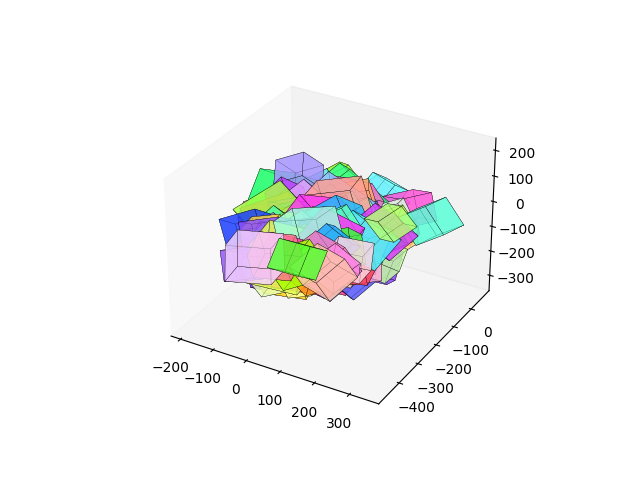

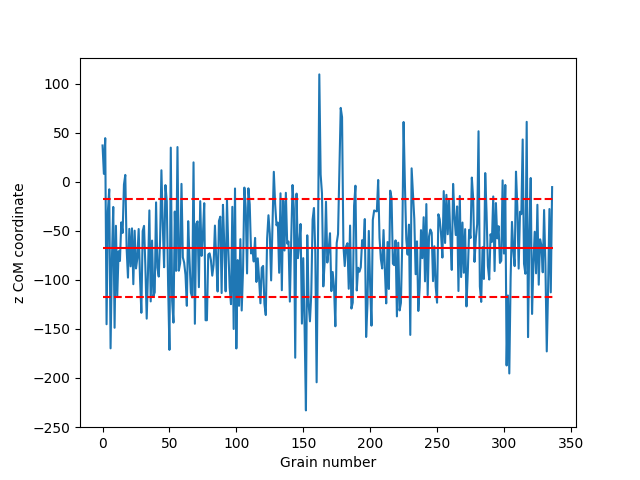

In [42]:
from dddxrd.visualization import Grainmap
gm = Grainmap.Grainmap(mapname)
fig,ax = gm.plot_3d_map()
zs = [g.translation[2] for g in gm.grains]
plt.figure()
plt.plot(zs)
plt.hlines(np.mean(zs),0,len(gm.grains),'r')
plt.hlines(np.mean(zs)-np.std(zs),0,len(gm.grains),'r',linestyles='dashed')
plt.hlines(np.mean(zs)+np.std(zs),0,len(gm.grains),'r',linestyles='dashed')
plt.xlabel('Grain number')
plt.ylabel('z CoM coordinate')

#### Compute average parameters optimizing each grain

In [43]:
import shutil
fitdir = os.path.join(analysisroot,sample,scan_name,'grainfits')
os.makedirs(fitdir,exist_ok=True)
os.chdir(fitdir)

'/Users/al8720/Library/CloudStorage/OneDrive-Malmöuniversitet/projects/castIron/ESRF22/analysis_23/tdxrd/linebeam/SiMo1000_6_v2/05_0N_3DXRD/grainfits/bccFrelon_unfitted_fitted.par'

In [44]:
refine_em = '/Users/al8720/Library/CloudStorage/OneDrive-Malmöuniversitet/code/ImageD11/scripts/refine_em.py'
run = f"{sys.executable} {refine_em} \
    {h5ubis} {mapname} {fitted_parfile} \
    --omega_slop=0.25 \
    -x wedge >null"
!{run}

/Users/al8720/Library/CloudStorage/OneDrive-Malmöuniversitet/code/ImageD11/ImageD11/transform.py:512: RuntimeWarning: invalid value encountered in arcsin
  tth = np.degrees(np.arcsin(s) * 2.) * valid
Traceback (most recent call last):
  File "/Users/al8720/Library/CloudStorage/OneDrive-Malmöuniversitet/code/ImageD11/scripts/fitgrain.py", line 104, in <module>
    fitgrain(options)
  File "/Users/al8720/Library/CloudStorage/OneDrive-Malmöuniversitet/code/ImageD11/scripts/fitgrain.py", line 39, in fitgrain
    o.fit(maxiters = options.steps)
  File "/Users/al8720/Library/CloudStorage/OneDrive-Malmöuniversitet/code/ImageD11/ImageD11/refinegrains.py", line 604, in fit
    newguess,error,iter=s.minimize(maxiters=maxiters , monitor=1)
  File "/Users/al8720/Library/CloudStorage/OneDrive-Malmöuniversitet/code/ImageD11/ImageD11/simplex.py", line 198, in minimize
    self.currenterror = self.testfunc(self.guess)
  File "/Users/al8720/Library/CloudStorage/OneDrive-Malmöuniversitet/code/ImageD

#### Compute the average of the grain parameters

In [46]:
print(f'We should have {len(grains)} par files here {fitdir}')
for i in range(len(grains)):
    filename = f'{i}.par'
    if not os.path.isfile(filename):
        print(f'{filename} is missing')
        print(f'Copying {i-1}.par to {filename}')
        shutil.copy(f'{i-1}.par',filename)

We should have 337 par files here /Users/al8720/Library/CloudStorage/OneDrive-Malmöuniversitet/projects/castIron/ESRF22/analysis_23/tdxrd/linebeam/SiMo1000_6_v2/05_0N_3DXRD/grainfits
17.par is missing
Copying 16.par to 17.par


In [51]:
avg_par ='/Users/al8720/Library/CloudStorage/OneDrive-Malmöuniversitet/code/ImageD11/scripts/avg_par.py'
final_par = f"{os.path.join(analysisroot,f'{sample}_{scan_name}.par')}"
run = f"{sys.executable} {avg_par} {final_par} {len(grains)}"
!{run}

distance 148783.1538839277 1077.9979883508395 [-4.35012027e+00 -3.38565056e+00 -2.51859620e+00 -2.37461154e+00
 -2.20737048e+00 -2.13528335e+00 -2.11662349e+00 -2.07958341e+00
 -1.96406633e+00 -1.89613922e+00 -1.85437949e+00 -1.85032584e+00
 -1.73798603e+00 -1.71168719e+00 -1.68732065e+00 -1.67170339e+00
 -1.66493006e+00 -1.64482091e+00 -1.59987840e+00 -1.59372541e+00
 -1.50459856e+00 -1.47156147e+00 -1.47147833e+00 -1.46961399e+00
 -1.43629450e+00 -1.42956384e+00 -1.42855278e+00 -1.42370397e+00
 -1.40403772e+00 -1.39703191e+00 -1.37180704e+00 -1.36602721e+00
 -1.33061952e+00 -1.30976066e+00 -1.30076783e+00 -1.25116238e+00
 -1.23947178e+00 -1.21746268e+00 -1.20924598e+00 -1.20714213e+00
 -1.18110896e+00 -1.15391646e+00 -1.14769405e+00 -1.14707913e+00
 -1.14375955e+00 -1.12593956e+00 -1.12344490e+00 -1.10991642e+00
 -1.10706797e+00 -1.09257513e+00 -1.06548684e+00 -1.03812098e+00
 -1.03010187e+00 -1.03001147e+00 -1.00366020e+00 -9.88557555e-01
 -9.70494596e-01 -9.68124192e-01 -9.46920761

#### Repeat makemap with the new parameters

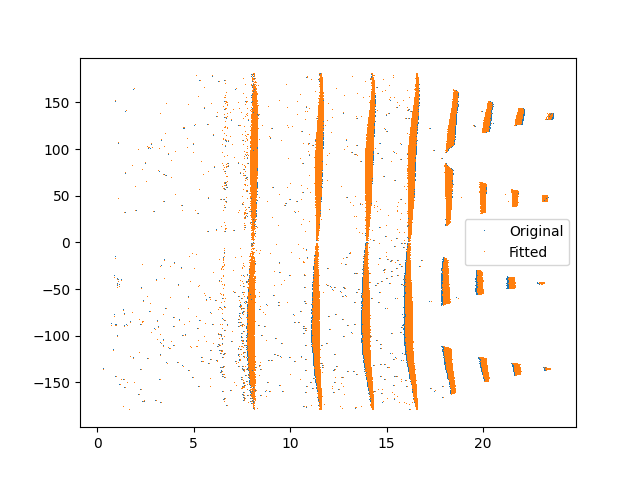

In [70]:
newcolf = cf.copy()
newcolf,outname=fit_geometry(newcolf,final_par,nfits=0)

mapped_grains = domap(newcolf, grains, OmSlop=0.25, tolseq=[0.05,0.03])
mapname = os.path.join(analysisroot,sample,scan_name,f'{scan_name}_{scan_id}.map')
ImageD11.grain.write_grain_file(mapname, mapped_grains)

/Users/al8720/Library/CloudStorage/OneDrive-Malmöuniversitet/code/DDDXRD/dddxrd/utils/crystallography.py:99: RuntimeWarning: invalid value encountered in arccos
  beta = np.arccos(gn[0]/(gn[0]**2+gn[1]**2))


Text(0, 0.5, 'z CoM coordinate')

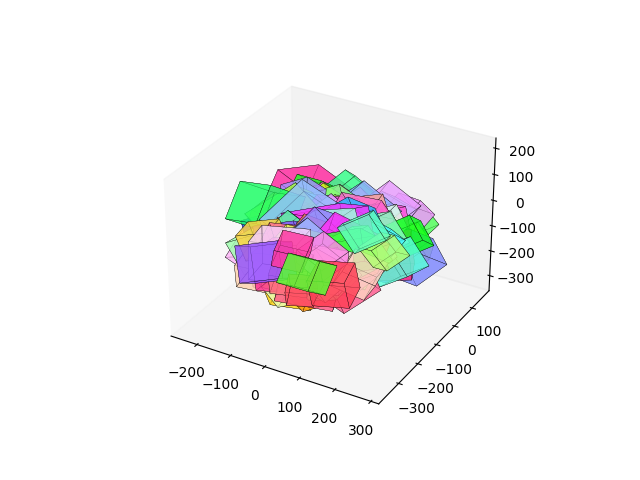

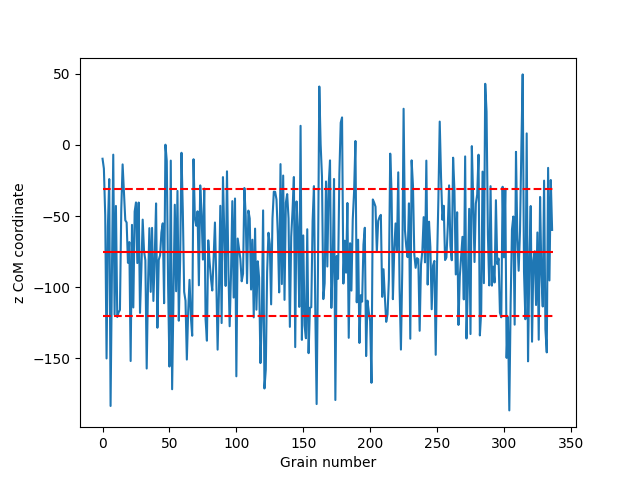

In [71]:
gm = Grainmap.Grainmap(mapname)
fig,ax = gm.plot_3d_map()
zs = [g.translation[2] for g in gm.grains]
plt.figure()
plt.plot(zs)
plt.hlines(np.mean(zs),0,len(gm.grains),'r')
plt.hlines(np.mean(zs)-np.std(zs),0,len(gm.grains),'r',linestyles='dashed')
plt.hlines(np.mean(zs)+np.std(zs),0,len(gm.grains),'r',linestyles='dashed')
plt.xlabel('Grain number')
plt.ylabel('z CoM coordinate')